In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import random
import numpy as np
import platform
import tensorflow
import keras
from keras import backend as K
from keras.models import load_model
from keras.utils import plot_model

from PIL import Image, ImageDraw, ImageFont
import colorsys
import imghdr
from yad2k.models.keras_yolo import yolo_eval, yolo_head
import cv2
from tqdm import tqdm
import time
import matplotlib
import matplotlib.pyplot as plt
import IPython.display as display

%matplotlib inline

Using TensorFlow backend.


In [2]:
root_dir = os.getcwd()
model_path = os.path.join(root_dir, "model_data")
classes_file_path = os.path.join(model_path, "coco_classes.txt")
model_filename = "yolov2_coco_608x608.h5"
model_file_path = os.path.join(model_path, model_filename)
anchors_filename = "yolov2_coco_608x608_anchors.txt"
anchors_file_path = os.path.join(model_path, anchors_filename)

img_height = 608
img_width = 608
img_channels = 3

score_threshold = 0.3

iou_threshold = 0.5

test_path = os.path.join(root_dir, "images")
output_path = os.path.join(root_dir, "imageout")

if not os.path.exists("output_path"):
    print('creating output folder {}'.format(output_path))
    os.mkdir(output_path)
    
sess = K.get_session()

creating output folder F:\notebook\deep learning\31\yad2k\imageout


In [3]:
with open(classes_file_path) as f:
    class_name = f.readlines()
    
class_names = [c.strip() for c in class_name]

In [4]:
with open(anchors_file_path) as f:
    anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    anchors = np.array(anchors).reshape(-1, 2)

In [5]:
yolo_model = load_model(model_file_path)
yolo_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
leaky_re_lu_12 (LeakyReLU)      (None, 38, 38, 256)  0           batch_normalization_12[0][0]     
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 38, 38, 512)  1179648     leaky_re_lu_12[0][0]             
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 38, 38, 512)  2048        conv2d_13[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_13 (LeakyReLU)      (None, 38, 38, 512)  0           batch_normalization_13[0][0]     
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 19, 19, 512)  0           leaky_re_lu_13[0][0]             
__________

In [6]:
num_classes = len(class_names)
num_anchors = len(anchors)

In [7]:
model_output_channels = yolo_model.layers[-1].output_shape[-1]
model_image_size = yolo_model.layers[0].input_shape

In [8]:
#对不同的bounding boxes 产生不同的颜色
hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]
colors = list(map(lambda x : colorsys.hsv_to_rgb(*x), hsv_tuples))
colors = list(map(lambda x : (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

random.seed(1)
random.shuffle(colors)
random.seed(None)

In [9]:
#将图层特征转换为边界框的相对参数
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

input_image_shape = K.placeholder(shape=(2, ))
boxes, scores, classes = yolo_eval(yolo_outputs,
                                   input_image_shape,
                                   score_threshold = score_threshold,
                                   iou_threshold=iou_threshold
                                  )

In [10]:
test_img = "person.jpg"
test_img_path = os.path.join(test_path, test_img)

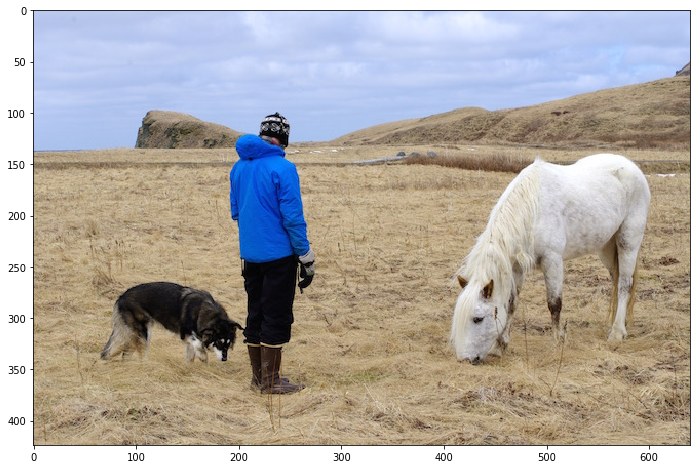

In [11]:
plt.figure(figsize=(15, 8))
img = plt.imread(test_img_path)
plt.imshow(img)

In [12]:
#preprocessing the image

image = Image.open(test_img_path)

resized_image = image.resize(tuple(reversed(model_image_size))[1:3], Image.BICUBIC)
image_data = np.array(resized_image, dtype='float32')

#normalize
image_data /= 255.

image_data = np.expand_dims(image_data, 0)

print(image_data.shape)

(1, 608, 608, 3)


In [13]:
out_boxes, out_scores, out_classes = sess.run([boxes, scores, classes],
                                             feed_dict={
                                                 yolo_model.input: image_data,
                                                 input_image_shape: [image.size[1], image.size[0]],
                                                 K.learning_phase(): 0
                                             })

print("out_boxes.shape:", out_boxes.shape, out_boxes.dtype)
print("out_scores.shape:", out_scores.shape, out_scores.dtype)
print("out_classes.shape:", out_classes.shape, out_classes.dtype)

out_boxes.shape: (3, 4) float32
out_scores.shape: (3,) float32
out_classes.shape: (3,) int64


In [14]:
# 打印出找到的n个box bounding  
print('Found {} boxes for {}'.format(len(out_boxes),test_img))

# 打印物体类别，confidence score 以及左上角和右下角的坐标
for i, c in reversed(list(enumerate(out_classes))):
    predicted_class = class_names[c]
    box = out_boxes[i]
    score = out_scores[i]
    
    top, left, bottom, right = box
    #防止左上角以及右下角的坐标超出边界
    top = max(0, np.floor(top + 0.5).astype('int32'))                   
    left = max(0, np.floor(left + 0.5).astype('int32'))                 
    bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32')) 
    right = min(image.size[0], np.floor(right + 0.5).astype('int32'))   
    
    label = '{} {:.2f} [({}, {}),({}, {})]'.format(predicted_class, score, top, left, bottom, right)
    print(label)

Found 3 boxes for person.jpg
dog 0.80 [(258, 70),(356, 209)]
person 0.81 [(97, 190),(379, 271)]
horse 0.89 [(129, 398),(352, 605)]


dog 0.80 (70, 258) (209, 356)
person 0.81 (190, 97) (271, 379)
horse 0.89 (398, 129) (605, 352)


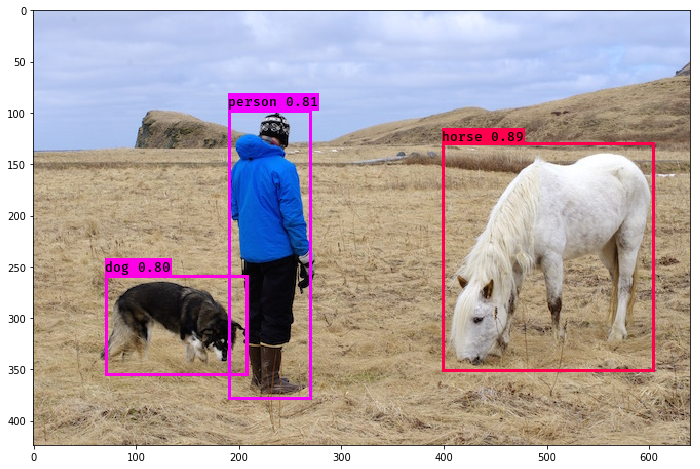

In [15]:
# 导入字体
font = ImageFont.truetype(font='font/FiraMono-Medium.otf',
                         size=np.floor(3e-2 * image.size[1]+0.5).astype('int32'))

# 设置box bounding的宽度
thickness = (image.size[0]+image.size[1]) // 300


for i, c in reversed(list(enumerate(out_classes))):
    predicted_class = class_names[c]
    box = out_boxes[i]
    score = out_scores[i]

    label = '{} {:.2f}'.format(predicted_class, score)

    draw = ImageDraw.Draw(image) 
    
    label_size = draw.textsize(label, font) # 物体类别与confidence score
    
    # "box bounding 的坐标
    top, left, bottom, right = box
    top = max(0, np.floor(top + 0.5).astype('int32'))
    left = max(0, np.floor(left + 0.5).astype('int32'))
    bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
    right = min(image.size[0], np.floor(right + 0.5).astype('int32'))

    # 输出图像类别以及坐标
    print(label, (left, top), (right, bottom))

    if top - label_size[1] >= 0:
        text_origin = np.array([left, top - label_size[1]])
    else:
        text_origin = np.array([left, top + 1])

    
    for i in range(thickness):
        #显示box bounding
        draw.rectangle(
            [left + i, top + i, right - i, bottom - i],
            outline=colors[c])
    
    # 设置矩形文字背景
    draw.rectangle(
        [tuple(text_origin), tuple(text_origin + label_size)],
        fill=colors[c])
    
    # 将文字输出到背景上
    draw.text(text_origin, label, fill=(0, 0, 0), font=font)
    
    del draw 

    
plt.figure(figsize=(15,8))
plt.imshow(image)


image.save(os.path.join(output_path, 'output.jpg'), quality=90)

In [16]:
sess.close()